In [ ]:
import torch
from torch import nn
from torchvision.models import resnet18, resnet34, resnet50
import torchvision
import cv2
import os
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!7z x '/content/drive/MyDrive/datasets/CCPD2019-dl1_part/train_100.zip'
!7z x '/content/drive/MyDrive/datasets/CCPD2019-dl1_part/test.zip'

# Подготовка данных

Определяем функцию преобразований изображения, формирования словаря и класс датасета. 

In [ ]:
import os
from PIL import Image
from torchvision import transforms
import unicodedata
from skimage import io


def transform(image):
    transform_ops = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=(0.485, 0.456, 0.406), 
        #                     std=(0.229, 0.224, 0.225)),
        transforms.Resize([32, 120])])
    
    return transform_ops(image)


def get_dicts(alphabet):
    '''Формирует два словаря, кодирующих символы в цифры
    Args: 
        alphabet: набор встречающихся символов, string
    Return:
        (letter_to_idx, idx_to_letter): кортеж из словарей
    '''
    
    letter_to_idx = {'-': 0}
    idx_to_letter = {0: '-'}

    for i, l in enumerate(alphabet):
        letter_to_idx.update({l: i+1})
        idx_to_letter.update({i+1: l})

    return (letter_to_idx, idx_to_letter)


class Dataset(torch.utils.data.Dataset):
    def __init__(self, path_data, dicts, transform):
        self.path_data = path_data
        self.transform = transform
        self.letter_to_idx, self.idx_to_letter = dicts
            
        self.idx_to_filename = []
        for filename in os.listdir(path_data):
            self.idx_to_filename.append(filename)
        
    def __len__(self):
        return len(self.idx_to_filename)
    
    def __getitem__(self, idx):
        image = io.imread(os.path.join(self.path_data, self.idx_to_filename[idx]))
        image = self.transform(image)
        text = self.idx_to_filename[idx].split("-")[1].split('.')[0]
        text = torch.tensor([self.letter_to_idx[l] for l in unicodedata.normalize('NFC', text)])

        return {'img': image, 'text': text}    

Ищем все используемые в датасете иероглифы

In [ ]:
a = set()

for filename in os.listdir('/content/train_1'):
    a.update(filename.split('.')[0].split('-')[1][0])
for filename in os.listdir('/content/test'):
    a.update(filename.split('.')[0].split('-')[1][0])

for i in a:
    print(i, end='')

津桂粤青吉皖辽豫浙陕鲁湘蒙宁冀云闽赣琼贵沪甘黑苏新京鄂晋渝川

Определяем алфавит и делим датасет на трейн и валидацию.  
Гугл колаб не может адекватно распаковать полный датасет из 200к изображений, поэтому я использовал только половину

In [ ]:
from torch.utils.data import random_split

alphabet = '蒙黑贵闽湘甘琼赣宁京浙鄂冀桂粤吉鲁皖苏云青沪渝新川晋津辽陕豫ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
ds = Dataset('/content/train_1', get_dicts(alphabet), transform)
ds_train, ds_val = random_split(ds, [80000, 20000])

# Создание и обучение модели

Определяем класс модели. Не стал использовать resnet из паторча, так как тот слишком сильно уменьшает размер изображения по вертикали + запрещено использовать предобученные модели, поэтому смысла от него не много.  
 
Использовал кастомную сверточную сеть из статьи про crnn. 

In [ ]:
class CRNN(torch.nn.Module):
    def __init__(self,  num_characters, input_height=32, 
                 rnn_input_size=256, rnn_hidden_size=256, leakyRelu=False):
        super(CRNN, self).__init__()
        self.input_height = input_height
        self.rnn_input_size = rnn_input_size
        self.rnn_hidden_size = rnn_hidden_size
        
        #resnet_modules = list(resnet18(pretrained=True).children())[:-2]
        #self.backbone = torch.nn.Sequential(*resnet_modules)
        
        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        self.backbone = torch.nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = 3 if i == 0 else nm[i - 1]
            nOut = nm[i]
            self.backbone.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                self.backbone.add_module('batchnorm{0}'.format(i), 
                                         nn.BatchNorm2d(nOut))
            if leakyRelu:
                self.backbone.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                self.backbone.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        self.backbone.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  
        convRelu(1)
        self.backbone.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  
        convRelu(2, True)
        convRelu(3)
        self.backbone.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        convRelu(4, True)
        convRelu(5)
        self.backbone.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        convRelu(6, True)

        self.map_to_seq = nn.Linear(512, self.rnn_input_size)
        self.rnn = nn.LSTM(self.rnn_input_size, self.rnn_hidden_size, 2, 
                           bidirectional=True, batch_first=True)
        self.predictor = nn.Linear(self.rnn_hidden_size * 2, num_characters)
        
        
    def forward(self, x):
        '''
        Args:
            x: shape: (batch_size, num_channels, height, width)
        Return:
            ans: тензор логитов, shape: (batch_size, seq_len, num_characters)
        '''
       
        assert x.shape[2] == self.input_height
        ans = self.backbone(x)
        #print(ans.shape)
        ans = ans.reshape(ans.shape[0], ans.shape[1] * ans.shape[2], 
                          ans.shape[3])  # Input: (batch_size, num_channels * map_height, map_length)
        ans = self.map_to_seq(ans.permute(0, 2, 1))  # Output shape: (batch_size, seq_len, rnn_input_size)
        ans = self.rnn(ans)[0]  # Output shape: (batch_size, seq_len, rnn_hidden_size * 2)
        ans = self.predictor(ans)  # Output shape: (batch_size, seq_len, num_characters)
        return ans

In [ ]:
import math
from torch import optim
import tqdm

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def train(model, ds_train, ds_val, batch_size, max_epochs, 
          lr, optimizer_state=None):
    
    history = {'train': [],
               'val': []}
    best_score = math.inf

    dl_train = DataLoader(ds_train, batch_size=batch_size)
    dl_val = DataLoader(ds_val, batch_size=batch_size)

    criterion = nn.CTCLoss(blank=0)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    if(optimizer_state is not None):
        optimizer.load_state_dict(torch.load(optimizer_state))

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    
    model.train()
    
    i = 0
    for epoch in range(max_epochs):
        err = []
        for batch in dl_train:
            optimizer.zero_grad()
            batch['img'] = batch['img'].to(device)
            batch['text'] = batch['text'].to(device)
            
            output = model(batch['img']) # Logits
            output = nn.functional.log_softmax(output, dim=2) # Log probs
            input_lengths = torch.full(size=(output.shape[0],), 
                                       fill_value=output.shape[1], 
                                       dtype=torch.int)
            target_lengths = batch['text'].count_nonzero(dim=1)
            
            # If width of backbone (cnn) output is less than number of 
            # symbols in word - throw exception 
            if(target_lengths.max() > input_lengths.max()):
                raise Exception('Backbone output is too short for this word') 
            
            loss = criterion(output.permute(1,0,2), batch['text'], 
                             input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            err.append(loss.item())
        
        history['train'].append(sum(err) / len(err))
        
        err = []
        with torch.no_grad():
            for batch in dl_val:
                batch['img'] = batch['img'].to(device)
                batch['text'] = batch['text'].to(device)

                output = model(batch['img']) # Logits
                output = nn.functional.log_softmax(output, dim=2) # Log probs
                input_lengths = torch.full(size=(output.shape[0],), 
                                           fill_value=output.shape[1], 
                                           dtype=torch.int)
                target_lengths = batch['text'].count_nonzero(dim=1)

                if(target_lengths.max() > input_lengths.max()):
                    raise Exception('Backbone output is too short for this word') 

                loss = criterion(output.permute(1,0,2), batch['text'], 
                                 input_lengths, target_lengths)

                err.append(loss.item())
        
        history['val'].append(sum(err) / len(err))
        print({ 'epoch': epoch, 'loss': sum(err) / len(err) })
        
        
        if(sum(err) / len(err) < best_score):
            best_score = sum(err) / len(err)
            print(f'saving {best_score}')
            torch.save(model.state_dict(), f'best.pt')
            torch.save(optimizer.state_dict(), f'opt_state_best.pt')
        
        
        if(i < 3):
            i += 1
        else:
            plt.plot(list(range(len(history['train']))), 
                     history['train'], label='train')
            plt.plot(list(range(len(history['val']))), 
                     history['val'], label='val')
            plt.legend()
            plt.show()
            i = 0
        

{'epoch': 0, 'loss': 2.64632488489151}
saving 2.64632488489151
{'epoch': 1, 'loss': 2.4598937153816225}
saving 2.4598937153816225
{'epoch': 2, 'loss': 1.842547845840454}
saving 1.842547845840454
{'epoch': 3, 'loss': 0.46771072447299955}
saving 0.46771072447299955


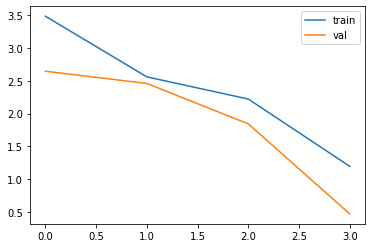

{'epoch': 4, 'loss': 0.05487170033156872}
saving 0.05487170033156872
{'epoch': 5, 'loss': 0.026186778955161572}
saving 0.026186778955161572
{'epoch': 6, 'loss': 0.018887486588209868}
saving 0.018887486588209868
{'epoch': 7, 'loss': 0.014699358446523546}
saving 0.014699358446523546


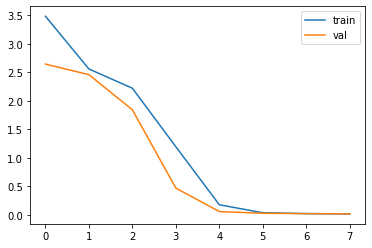

{'epoch': 8, 'loss': 0.011627470469102263}
saving 0.011627470469102263
{'epoch': 9, 'loss': 0.012746903579682112}
{'epoch': 10, 'loss': 0.010707567352801562}
saving 0.010707567352801562
{'epoch': 11, 'loss': 0.010084531269967556}
saving 0.010084531269967556


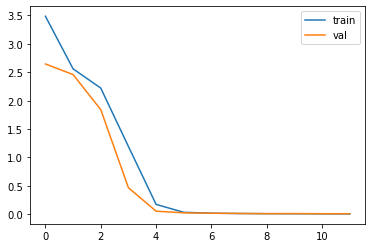

{'epoch': 12, 'loss': 0.009184225858189166}
saving 0.009184225858189166
{'epoch': 13, 'loss': 0.007161884871311486}
saving 0.007161884871311486
{'epoch': 14, 'loss': 0.007506741129327565}
{'epoch': 15, 'loss': 0.006528516905382276}
saving 0.006528516905382276


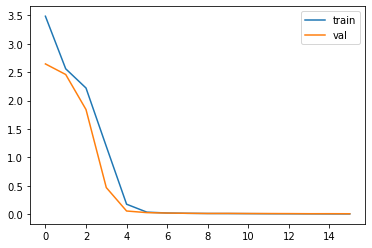

{'epoch': 16, 'loss': 0.006206821056548506}
saving 0.006206821056548506
{'epoch': 17, 'loss': 0.46168507933616637}
{'epoch': 18, 'loss': 0.02312133451923728}
{'epoch': 19, 'loss': 0.014791211299598216}


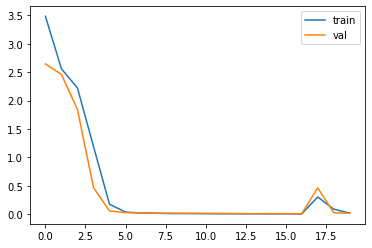

{'epoch': 20, 'loss': 0.011580140236765147}
{'epoch': 21, 'loss': 0.009834986226633192}


ValueError: ignored

In [ ]:
model = CRNN(len(alphabet)+1, input_height=32)
train(model, ds_train, ds_val, 1000, 50, 0.001)

In [ ]:
import gc

gc.collect()

880

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

Дообучаем на уменьшенном lr

In [ ]:
model.load_state_dict(torch.load('/content/best.pt'))

<All keys matched successfully>

{'epoch': 0, 'loss': 0.00681027458049357}
saving 0.00681027458049357
{'epoch': 1, 'loss': 0.0073656484484672545}
{'epoch': 2, 'loss': 0.006741683359723538}
saving 0.006741683359723538
{'epoch': 3, 'loss': 0.006128999125212431}
saving 0.006128999125212431


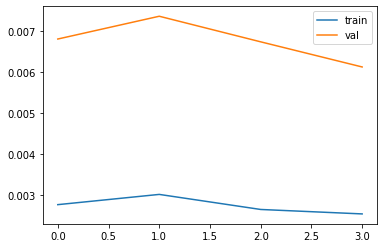

{'epoch': 4, 'loss': 0.006499729305505753}
{'epoch': 5, 'loss': 0.004552751290611922}
saving 0.004552751290611922
{'epoch': 6, 'loss': 0.004728367773350328}
{'epoch': 7, 'loss': 0.004481811972800643}
saving 0.004481811972800643


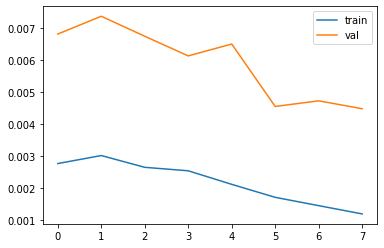

{'epoch': 8, 'loss': 0.004168154357466846}
saving 0.004168154357466846
{'epoch': 9, 'loss': 0.004192635451909154}
{'epoch': 10, 'loss': 0.004049936862429604}
saving 0.004049936862429604
{'epoch': 11, 'loss': 0.003956290835049003}
saving 0.003956290835049003


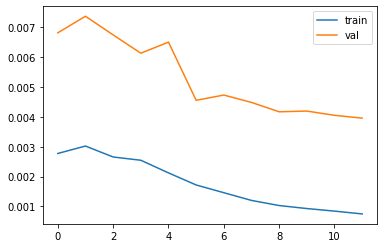

{'epoch': 12, 'loss': 0.003938502620439976}
saving 0.003938502620439976


KeyboardInterrupt: ignored

In [ ]:
train(model, ds_train, ds_val, 1000, 20, 0.0001, optimizer_state='/content/opt_state_best.pt')

# Подсчет метрик

In [ ]:
letter_to_idx, idx_to_letter = get_dicts(alphabet)

def clean(pred):
    '''Преобразует выход CTC лосса, удаляя blank символы и склеивая буквы
    Args:
        pred: декодированный выход CTC лосса, list
    Return:
        pred_cleaned: преобразованный pred, list

    '''

    pred_cleaned = ''
    for i in range(len(pred) - 1):
        if(pred[i+1] != pred[i] and pred[i] != '-'):
            pred_cleaned += pred[i]

    return pred_cleaned


def predict(model, image, idx_to_letter, transform=None):
    '''Предсказывает одно единственное изображение
    Args:
        model: модель, которой производится предсказание. CRNN
        image: изображение. torch.tensor, если transform не определен, 
                            numpy array, если определен transform, 
                            преобразующий image в torch.tensor
        idx_to_letter: словарь преобразующий индекс символа в символ
        transform: набор торчевых преобразований для image. transforms.Compose
    Return:
        pred_cleaned: выход функции clean

    '''
    
    if(transform is not None):
        image = transform(image)
    plt.imshow(image.permute(1,2,0))

    image = image.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        pred = model(image.to(device))
                
    pred = [idx_to_letter[s.item()] for s in pred.squeeze().argmax(dim=1)]
    
    return clean(pred)


def predict_dataset(model, dataset, batch_size):
    '''Предсказывает каждое изображение в тестовом датасете
    Args:
        model: модель, которой производится предсказание. CRNN
        dataset: тестовый датасет. Dataset
        batch_size: размер батча. int
    Return:
        out: словарь с двумя списками - предсказанная строка и истинная. dict
    '''
    dl = DataLoader(dataset, batch_size=batch_size)
    if use_cuda:
        model = model.cuda()
    model.eval()

    out = {'preds': [],
           'targets': []}

    with torch.no_grad():
        for batch in dl:
            batch['img'] = batch['img'].to(device)
            batch['text'] = batch['text'].to(device)

            output = model(batch['img']) # Logits
            for i in range(output.shape[0]):
                pred = [idx_to_letter[s.item()] for s in output[i].argmax(dim=1)]
                target = ''.join([idx_to_letter[s.item()] for s in batch['text'][i]])

                out['preds'].append(clean(pred))
                out['targets'].append(target)

    return out

In [ ]:
ds_test = Dataset('/content/test', get_dicts(alphabet), transform)

In [ ]:
model = CRNN(len(alphabet)+1, input_height=32)
model.load_state_dict(torch.load('/content/best.pt', map_location=device))

<All keys matched successfully>

In [ ]:
preds = predict_dataset(model, ds_test, 1000)

In [ ]:
def accuracy(preds, targets, return_matches=False):
    assert len(preds) == len(targets)
    matches = [pred == target for pred, target in zip(preds, targets)]
    
    if(return_matches):
        return (matches.count(True) / len(targets), matches)
    else:
        return matches.count(True) / len(targets)

In [ ]:
from torchmetrics.functional import char_error_rate

print(f"CER: {char_error_rate(preds['preds'], preds['targets'])}")
print(f"Accuracy: {accuracy(preds['preds'], preds['targets'])}")

CER: 0.0034432015381753445
Accuracy: 0.978997899789979


# Анализ ошибок модели

In [ ]:
acc, mat = accuracy(preds['preds'], preds['targets'], return_matches=True)

In [ ]:
indexes = []

for i, m in enumerate(mat):
    if(m == False):
        indexes.append(i)
        
print(indexes)

[2, 48, 67, 108, 110, 118, 214, 323, 326, 337, 372, 443, 470, 474, 599, 632, 720, 721, 813, 874, 880, 920, 960, 1000, 1034, 1097, 1098, 1134, 1312, 1324, 1392, 1526, 1582, 1584, 1723, 1727, 1811, 1836, 1843, 1940, 2010, 2068, 2095, 2098, 2160, 2197, 2268, 2271, 2272, 2322, 2402, 2456, 2504, 2551, 2660, 2661, 2781, 2790, 2804, 2814, 2859, 2917, 2973, 3117, 3256, 3406, 3470, 3509, 3550, 3565, 3610, 3634, 3646, 3690, 3835, 3934, 3941, 3956, 3989, 4012, 4023, 4068, 4132, 4281, 4455, 4479, 4487, 4492, 4503, 4515, 4552, 4572, 4574, 4579, 4677, 4680, 4732, 4867, 4886, 4900, 4934, 4941, 4950, 4955, 5020, 5071, 5072, 5080, 5118, 5207, 5374, 5400, 5455, 5514, 5543, 5607, 5624, 5664, 5694, 5782, 5863, 5974, 6035, 6046, 6050, 6082, 6115, 6132, 6271, 6361, 6514, 6537, 6539, 6606, 6683, 6687, 6723, 6737, 6823, 6871, 6906, 6931, 6941, 6988, 6998, 7011, 7033, 7056, 7068, 7145, 7284, 7286, 7290, 7295, 7325, 7373, 7400, 7434, 7448, 7478, 7720, 7809, 7818, 7830, 7876, 7934, 7989, 7996, 8033, 8039, 8047, 

In [ ]:
def demonstrate(id):
    item = ds_test.__getitem__(id)
    plt.imshow(item['img'].permute(1,2,0))
    print('pred:')
    print(predict(model, item['img'], idx_to_letter))
    print('true:')
    print(''.join([idx_to_letter[i.item()] for i in item['text']]))

Можно заметить, что, в основном, ошибки в распознавании возникают из за наличия грязи на номере.

pred:
皖A915C
true:
皖AJ915C


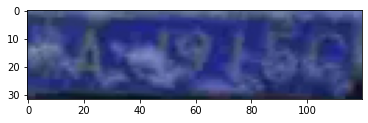

In [ ]:
demonstrate(2)

pred:
苏BE767V
true:
苏BE767W


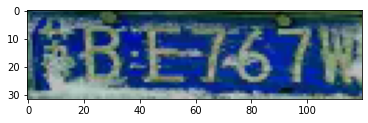

In [ ]:
demonstrate(632)

pred:
皖AM0T99
true:
皖AD0T89


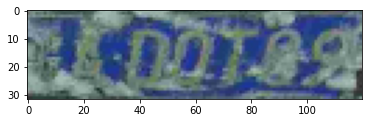

In [ ]:
demonstrate(721)

Также причинами ошибок являются очень низкое качество изображения (размытие и смазывание) и появление мало распространенных в обучающей выборке иероглифов.  

С первой проблемой может помочь применение к датасету аугментаций, со второй - предобучение модели на датасете китайских иероглифов

pred:
皖A11178
true:
皖AH1178


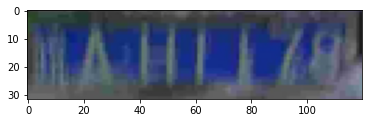

In [ ]:
demonstrate(100)

pred:
皖APY62
true:
皖APY862


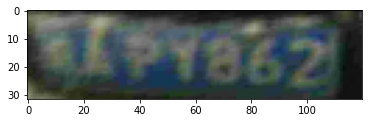

In [ ]:
demonstrate(697)

pred:
闽N6H339
true:
鄂N6H339


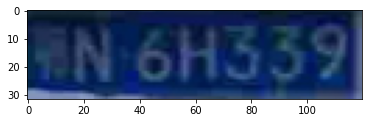

In [ ]:
demonstrate(811)

pred:
冀A7172J
true:
贵A7172J


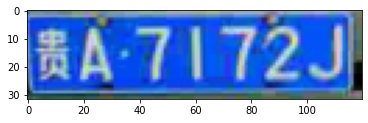

In [ ]:
demonstrate(342)